In [189]:
import numpy as np
import pandas as pd
from sklearn.datasets import load_boston
from sklearn.metrics import r2_score
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split

import torch
from torch import nn
import torch.optim as optim

from sklearn import tree

### Splitting Criteria: RSS

Let us now build the regression tree. We start by implementing the splitting criteria which is used to decide the most discriminative features at each step. We use $RSS$ which is computed as follows:

$$RSS =\sum_{\text {left }}\left(y_{i}-\hat{y_{L}}\right)^{2}+\sum_{\text {right }}\left(y_{i}-\hat{y_{R}}\right)^{2}$$

where $\hat{y_L} and \hat{y_r}$ are mean y-value of left and right nodes.

In [262]:
def rss(y_left, y_right):
    def squared_residual_sum(y):
        return np.sum((y - np.mean(y)) ** 2)
    
    return squared_residual_sum(y_left) + squared_residual_sum(y_right) 

### Threshold aggregation approach 

In [268]:
def find_best_rule_federated(X_train, y_train):
    best_feature, best_threshold, min_rss = None, None, np.inf
    best_thres = [None]*len(X_train[0].columns)
    rss_feature = [None]*len(X_train[0].columns)
    
    if type(X_train[0]) == pd.core.series.Series:
        X_train[0] = X_train[0].to_frame()
    
    for idx, feature in enumerate(X_train[0].columns):
        thresholds = [None]*len(X_train)
        best_threshold = [None]*len(X_train)
        
        for i in range(len(X_train)):
            min_rss = np.inf
            thresholds[i] = X_train[i][feature].unique().tolist()
            
            thresholds[i].sort()
            
            
            for t in thresholds[i]:
                y_left_ix = X_train[i][feature] < t
                y_left, y_right = y_train[i][y_left_ix], y_train[i][~y_left_ix]
                t_rss = rss(y_left, y_right)
                if t_rss.item() < min_rss:
                    min_rss = t_rss.item()
                    best_threshold[i] = t
                
                
        best_thres[idx] = np.mean(best_threshold)
        y_left_ix = X_train[i][feature] < best_thres[idx]
        y_left, y_right = y_train[i][y_left_ix], y_train[i][~y_left_ix]
        rss_feature[idx] = rss(y_left, y_right)
    best_feature = X_train[0].columns[np.argmin(rss_feature)]
    best_threshold = best_thres[np.argmin(rss_feature)]

    return {'feature': best_feature, 'threshold': best_threshold}


def split_federated(X_train, y_train, depth, max_depth):
    
    if depth == max_depth or len(min(X_train, key=len)) < 2:
        y_means = []
        for i in y_train: 
            y_means.append(np.mean(i))
        return {'prediction': np.mean(y_means)}
    
    rule = find_best_rule_federated(X_train, y_train)
    X_train_left = [None]*len(X_train)
    y_train_left = [None]*len(X_train)
    X_train_right = [None]*len(X_train)
    y_train_right = [None]*len(X_train)
    
    for i in range(len(X_train)): 
        left_ix = X_train[i][rule['feature']] < rule['threshold']
        X_train_left[i] = X_train[i][left_ix]
        y_train_left[i] = y_train[i][left_ix]
        X_train_right[i] = X_train[i][~left_ix]
        y_train_right[i] = y_train[i][~left_ix]

    
    rule['left'] = split_federated(X_train_left, y_train_left, depth + 1, max_depth)
    rule['right'] = split_federated(X_train_right, y_train_right, depth + 1, max_depth)
    return rule

def predict(sample, rules):
    prediction = None
    while prediction is None:
        feature, threshold = rules['feature'], rules['threshold']
        if sample[feature] < threshold:
            rules = rules['left']
        else:
            rules = rules['right']
        prediction = rules.get('prediction', None)
    return prediction

def evaluate_fed(X, y):
    preds = X.apply(predict, axis='columns', rules=rules_fed.copy())
    return r2_score(preds, y)

### Random forest style aggregation 

In [267]:
def find_best_rule_forest(X_train, y_train):
    best_feature, best_threshold, min_rss = None, None, np.inf
    for feature in X_train.columns:
        thresholds = X_train[feature].unique().tolist()
        thresholds.sort()
        thresholds = thresholds[1:]
        for t in thresholds:
            y_left_ix = X_train[feature] < t
            y_left, y_right = y_train[y_left_ix], y_train[~y_left_ix]
            t_rss = rss(y_left, y_right)
            if t_rss.item() < min_rss:
                min_rss = t_rss.item()
                best_threshold = t
                best_feature = feature
    
    return {'feature': best_feature, 'threshold': best_threshold}

def split_forest(X_train, y_train, depth, max_depth):
    if depth == max_depth or len(X_train) < 2:
        return {'prediction': np.mean(y_train)}
    
    rule = find_best_rule_forest(X_train, y_train)
    left_ix = X_train[rule['feature']] < rule['threshold']
    rule['left'] = split_forest(X_train[left_ix], y_train[left_ix], depth + 1, max_depth)
    rule['right'] = split_forest(X_train[~left_ix], y_train[~left_ix], depth + 1, max_depth)
    return rule

def forest(X_train, y_train, depth, max_depth):
    trees = []
    for i in  range(len(X_train)):
        trees.append(split_forest(X_train[i],y_train[i], depth, max_depth))
    return trees


def predict_forest(sample, rules_forest):

    predi = []
    rules = [None]*len(rules_forest)
    for i in range(len(rules)):
        rules[i] = rules_forest[i].copy()
        prediction = None
        while prediction is None:
            feature, threshold = rules[i]['feature'], rules[i]['threshold']

            if sample[feature] < threshold:
                rules[i] = rules[i]['left']
            else:
                rules[i] = rules[i]['right']

            prediction = rules[i].get('prediction', None)

        predi.append(prediction)

    return np.mean(predi)

        
def evaluate_forest(X, y):
    preds = X.apply(predict_forest, axis='columns', rules_forest = forest_rules.copy())
    return r2_score(preds, y)


### Default tree 

In [266]:
def find_best_rule(X_train, y_train):
    best_feature, best_threshold, min_rss = None, None, np.inf
    
    if type(X_train) == pd.core.series.Series:
        X_train = X_train.to_frame()
    
    
    for feature in X_train.columns:
        thresholds = X_train[feature].unique().tolist()
        thresholds.sort()
        thresholds = thresholds[1:]
        for t in thresholds:
            y_left_ix = X_train[feature] < t
            y_left, y_right = y_train[y_left_ix], y_train[~y_left_ix]
            t_rss = rss(y_left, y_right)
            if t_rss < min_rss:
                min_rss = t_rss
                best_threshold = t
                best_feature = feature
    
    return {'feature': best_feature, 'threshold': best_threshold}



def split(X_train, y_train, depth, max_depth):
    if depth == max_depth or len(X_train) < 2:

        return {'prediction': np.mean(y_train)}
    
    rule = find_best_rule(X_train, y_train)

    left_ix = X_train[rule['feature']] < rule['threshold']
    rule['left'] = split(X_train[left_ix], y_train[left_ix], depth + 1, max_depth)
    rule['right'] = split(X_train[~left_ix], y_train[~left_ix], depth + 1, max_depth)
    return rule

def predict(sample, rules):
    prediction = None
    while prediction is None:
        feature, threshold = rules['feature'], rules['threshold']
        if sample[feature] < threshold:
            rules = rules['left']
        else:
            rules = rules['right']
        prediction = rules.get('prediction', None)
        
    return prediction


def evaluate(X, y):
    preds = X.apply(predict, axis='columns', rules=rules.copy())
    return r2_score(preds, y)


### Random example 

In [123]:
def prepare_dataset():
    boston = load_boston()
    X_y = np.column_stack([boston['data'], boston['target']])
    np.random.seed(1)
    np.random.shuffle(X_y)
    
    X, y = X_y[:,:-1], X_y[:,-1]
    X_train, y_train, X_test, y_test = X[:400], y[:400], X[400:], y[400:]
    X_train = pd.DataFrame(X_train, columns=boston['feature_names'])
    X_test = pd.DataFrame(X_test, columns=boston['feature_names'])
    y_train = pd.Series(y_train, name='House Price')
    y_test = pd.Series(y_test, name='House Price')
    return X_train, y_train, X_test, y_test





In [6]:
a = np.array_split(X_train, 3)
type(a[0])

pandas.core.frame.DataFrame

In [372]:
X_train, y_train, X_test, y_test = prepare_dataset()

rules = split(X_train, y_train, 0, 3)

train_r2 = evaluate(X_train, y_train)
test_r2 = evaluate(X_test, y_test)
print('Training R2:', train_r2, 'Test R2:',test_r2)

Training R2: 0.7708091374308115 Test R2: 0.7196592096391115


In [143]:
X_train, y_train, X_test, y_test = prepare_dataset()
X_train["y"] = y_train
a = np.array_split(X_train, 3)
a
x_t = []
y_t = []
for i in range(0,3): 
    x_t.append(a[i].loc[:, a[i].columns != 'y'])
    y_t.append(a[i].loc[:, a[i].columns == 'y'])

rules_fed = split_federated(x_t, y_t, 0, 3)

#train_r2 = evaluate_fed(X_train, y_train)
test_r2 = evaluate_fed(X_test, y_test)
print('Test R2:',test_r2)

3
{'feature': 'LSTAT', 'threshold': 9.236666666666666}
{'feature': 'LSTAT', 'threshold': 5.216666666666666}
{'feature': 'CRIM', 'threshold': 0.7158766666666666}
35.57714285714286
49.03333333333333
{'feature': 'RM', 'threshold': 7.129666666666666}
24.400026881720432
36.01777777777778
{'feature': 'LSTAT', 'threshold': 16.546666666666667}
{'feature': 'LSTAT', 'threshold': 11.533333333333333}
22.249603174603177
19.492597701149425
{'feature': 'CRIM', 'threshold': 6.006896666666666}
16.633015873015868
11.944004329004331
Test R2: 0.4918790710957702


In [176]:
X_train, y_train, X_test, y_test = prepare_dataset()
X = X_train.sample(n = 40).sort_index()
y = y_train[y_train.index.isin(X.index)]

rules = split(X, y,0,3)

test_r2 = evaluate(X_test,y_test)
print(test_r2)

{'feature': 'RM', 'threshold': 6.982}
{'feature': 'DIS', 'threshold': 1.9512}
{'feature': 'CRIM', 'threshold': 9.91655}
14.680000000000001
10.0
{'feature': 'LSTAT', 'threshold': 10.24}
24.472727272727276
20.46153846153846
{'feature': 'RM', 'threshold': 7.831}
{'feature': 'INDUS', 'threshold': 6.96}
32.4
35.2
{'feature': 'CRIM', 'threshold': 0.31533}
50.0
47.4
0.4379592980507183


In [179]:
type(cc.to_numpy())

numpy.ndarray

In [166]:
X_train, y_train, X_test, y_test = prepare_dataset()
X_train["y"] = y_train
a = np.array_split(X_train, 10)

x_t = []
y_t = []
for i in range(0,10): 
    x_t.append(a[i].loc[:, a[i].columns != 'y'])
    y_t.append(a[i].loc[:, a[i].columns == 'y'])

forest_rules = forest(x_t,y_t, 0,5)

test_r2 = evaluate_forest(X_test,y_test)
print(test_r2)

0.6021822198266922


In [212]:
X_train, y_train, X_test, y_test = prepare_dataset()
X = X_train.sample(n = 40).sort_index()
y = y_train[y_train.index.isin(X.index)]

clf = tree.DecisionTreeRegressor(max_depth=5)
clf = clf.fit(X, y)
pred = clf.predict(X_test)

r2_score(pred, y_test)


0.4928223021422895

## Test with toy data 

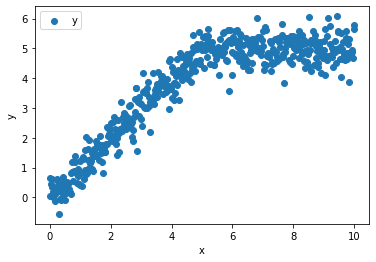

In [272]:
rng = np.random.default_rng()
x = np.linspace(0, 10, 500)

y = np.where(x < 5, x, 5) + rng.normal(0, 0.4, size=x.shape)
#x = x.reshape(-1,1)

df = pd.DataFrame({'x' : x, "x_2": x, 'y' : y})

#hide_input

plt.scatter(x,y, label='y')
plt.xlabel('x')
plt.ylabel('y')
plt.legend();

In [273]:
X_train, X_test, y_train, y_test = train_test_split(df["x"].to_frame(), df["y"], test_size=0.33, random_state=42)

X_train["y"] = y_train
a = np.array_split(X_train, 5)

x_t = []
y_t = []
for i in range(0,5): 
    x_t.append(a[i].loc[:, a[i].columns != 'y'])
    y_t.append(a[i].loc[:, a[i].columns == 'y'])

forest_rules = forest(x_t,y_t, 0,3)

test_r2 = evaluate_forest(X_test,y_test)
print(test_r2)




0.9466868596422234


In [274]:
X_train, X_test, y_train, y_test = train_test_split(df[["x","x_2"]], df["y"], test_size=0.33, random_state=42)

X = X_train.sample(n = 100).sort_index()
y = y_train[y_train.index.isin(X.index)]

rules = split(X, y,0,3)

test_r2 = evaluate(X_test,y_test)
print(test_r2)



0.9430353312164633


In [276]:
X_train, X_test, y_train, y_test = train_test_split(df[["x"]], df["y"], test_size=0.33, random_state=42)

X_train["y"] = y_train
a = np.array_split(X_train, 5)

x_t = []
y_t = []
for i in range(0,5): 
    x_t.append(a[i].loc[:, a[i].columns != 'y'])
    y_t.append(a[i].loc[:, a[i].columns == 'y'])

rules_fed = split_federated(x_t, y_t, 0, 3)

#train_r2 = evaluate_fed(X_train, y_train)
test_r2 = evaluate_fed(X_test, y_test)
print('Test R2:',test_r2)

Test R2: 0.9396827196778756
